## Here we are going to analyse the Reviews of all airports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data loading

In [2]:
df_reviews = pd.read_csv('../data/final_df_reviews.csv')
df_reviews.head()

,Country,Airport,Date,Content,General Stars,Getting to the Airport,Terminal facilities,WiFi,Food and retail services,Lounge,Immigration/customs,Baggage claim,Security check
0,Afghanistan,Herat International Airport,2012-05-13,Nice building. Looks like a train station :),3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,Kabul International Airport,2019-11-08,The Kabul airport has improved. It's a lot cle...,3,4.0,3.0,3.0,3.0,2.0,NaN,NaN,4.0
2,Afghanistan,Kabul International Airport,2015-09-07,Immigration officials looking for bribes. Too ...,1,4.0,2.0,1.0,1.0,2.0,NaN,NaN,3.0
3,Afghanistan,Kabul International Airport,2014-05-30,"Merger facilities. Terrible bathrooms, dirty m...",2,4.0,2.0,1.0,2.0,2.0,2.0,2.0,NaN
4,Afghanistan,Kabul International Airport,2014-05-20,"The worst ""¿International Airport?"" I have eve...",1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


## Data overview

``Data type`` :
- On verifie les types de données qu'on va traité, et voir si y'a pas des changements à faire
- Par exemple, on pourrait changer le type de la "Date"

In [3]:
df_type = pd.DataFrame([(column, df_reviews[column].dtype) for column in df_reviews.columns], columns=['Column', 'Type'])
df_type

,Column,Type
0,Country,object
1,Airport,object
2,Date,object
3,Content,object
4,General Stars,int64
5,Getting to the Airport,float64
6,Terminal facilities,float64
7,WiFi,float64
8,Food and retail services,float64
9,Lounge,float64


``NaN values``

In [4]:
def get_nan_rows(df):
    null_df = [df[df[column].isna()] for column in df.columns]
    stats_df = [(column, df[column].isna().sum(), (df[column].isna().sum() / df.shape[0]) * 100) for column in df.columns]
    stats_df = pd.DataFrame(stats_df, columns=["column", "nan_count", "nan_percentage"])
    return null_df, stats_df

null_df, stats_df = get_nan_rows(df_reviews)

- On constate plusieurs valeurs manquantes, en effet l'utilisateur à du remplir directement la note generale sans passer en détail sur tout les autres aspect

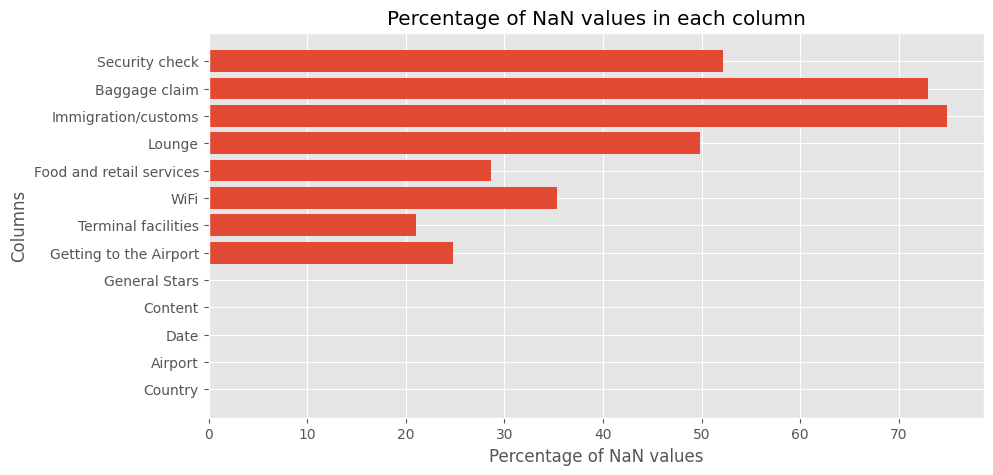

In [5]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.barh(stats_df["column"], stats_df["nan_percentage"])
plt.xlabel("Percentage of NaN values")
plt.ylabel("Columns")
plt.title("Percentage of NaN values in each column")
plt.show()

``Anomalies``

In [6]:
def impossible_rating_anomaly():
    """If rating is less than 0 or greater than 5, it is an anomaly"""
    print("=====================================================")
    print("Checking for anomalies in ratings...")
    for column in df_reviews.columns[5:]:
        anomalies = df_reviews[(df_reviews[column] < 0) | (df_reviews[column] > 5)]
        if anomalies.shape[0] > 0:
            print(f"Anomalies in column {column}:")
            print(anomalies)
        else:
            print(f"No anomalies in column {column}")

def impossible_general_star_rating_anomaly(verbose=False):
    """If general star is too much different for the mean of the other ratings, it is an anomaly"""
    print("=====================================================")
    print("Checking for anomalies in general star rating...")
    anomalies = []
    typing_anomalies = []
    for row in df_reviews.itertuples():
        row_mean, row_count = 0, 0
        for value in row[6:]:
            if pd.isna(value):
                continue
            row_count += 1
            row_mean += value
        if row_count == 0:
            continue
        row_mean = row_mean / row_count

        if row_mean == 0:
            typing_anomalies.append(row.Index)
        elif abs(row[5] - row_mean) > 1:
            if verbose:
                print(f"Anomaly in row {row.Index}, general star: {row[5]}, mean: {row_mean}, count: {row_count}")
            anomalies.append(row.Index)    

    if len(anomalies) == 0:
        print("No anomalies found")
    else:
        print(f"Found {len(anomalies)} anomalies")

    if len(typing_anomalies) == 0:
        print("No typing anomalies found")
    else:
        print(f"Found {len(typing_anomalies)} typing anomalies")

    return anomalies, typing_anomalies

impossible_rating_anomaly()
bad_index, index_to_process = impossible_general_star_rating_anomaly(verbose=False)

Checking for anomalies in ratings...
No anomalies in column Getting to the Airport
No anomalies in column Terminal facilities
No anomalies in column WiFi
No anomalies in column Food and retail services
No anomalies in column Lounge
No anomalies in column Immigration/customs
No anomalies in column Baggage claim
No anomalies in column Security check
Checking for anomalies in general star rating...
Found 993 anomalies
Found 38 typing anomalies


``Row of anomalies``
- Ici on detecte les notes ou l'utilisateurs à potentiellement mal attribué la note global de l'aeroport
- Par exemple l'utilisateur met une note de 5 etoiles en générale, mais 1 étoile sur tout les autres aspect ? => Incohérence

In [7]:
df_reviews[df_reviews.index.isin(bad_index)].head(3)

,Country,Airport,Date,Content,General Stars,Getting to the Airport,Terminal facilities,WiFi,Food and retail services,Lounge,Immigration/customs,Baggage claim,Security check
2,Afghanistan,Kabul International Airport,2015-09-07,Immigration officials looking for bribes. Too ...,1,4.0,2.0,1.0,1.0,2.0,NaN,NaN,3.0
15,Albania,Tirana International Airport,2020-09-26,Пассажиров на рейс в Киев не пускали в аэропор...,2,5.0,3.0,NaN,NaN,NaN,NaN,NaN,5.0
16,Albania,Tirana International Airport,2017-12-10,The first international airport where you can ...,1,5.0,1.0,4.0,1.0,1.0,NaN,NaN,3.0


``Row of typing anomalies``
- Ici on detecte la même chose, mais ou l'utilisateur à juste pas mis les notes en détail, mais du fait que il a accédé à l'onglet à ça tout mis à 0

In [8]:
df_reviews[df_reviews.index.isin(index_to_process)].head(3)

,Country,Airport,Date,Content,General Stars,Getting to the Airport,Terminal facilities,WiFi,Food and retail services,Lounge,Immigration/customs,Baggage claim,Security check
28,Algeria,Algiers Houari Boumediene Airport,2015-01-15,"One of the nicest in Africa, very bright and c...",4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
36,Algeria,Tlemcen Zenata Airport,2014-11-21,L'aéroport de Tlemcen est un petit aéroport re...,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
46,Angola,Luanda Quatro de Fevereiro Airport,2014-08-22,You are lucky if you are not arrested by the a...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## Data cleaning

- On fill les missing values des dates en utilisant la method ffill qui prend la date d'avant valide et la propage => à revoir
- On fill les missing values des ratings avec la valeur de General stars, étant donné que c'est censé être la note final
- Ceci semble être l'approche qui biaise le moins nos données? => à voir

In [9]:
def convert_to_good_date_type():
    """Convert the date column to datetime type"""
    df_reviews["Date"] = pd.to_datetime(df_reviews["Date"], format='%Y-%m-%d')

def fill_nan_by_general_star():
    """Fill NaN values in the ratings with the general star rating"""
    for column in df_reviews.columns[5:]:
        df_reviews[column].fillna(df_reviews["General Stars"], inplace=True)

def fill_date():
    df_reviews["Date"].fillna(method='ffill', inplace=True)

convert_to_good_date_type()
fill_date()
fill_nan_by_general_star()
df_reviews.head()

,Country,Airport,Date,Content,General Stars,Getting to the Airport,Terminal facilities,WiFi,Food and retail services,Lounge,Immigration/customs,Baggage claim,Security check
0,Afghanistan,Herat International Airport,2012-05-13,Nice building. Looks like a train station :),3,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
1,Afghanistan,Kabul International Airport,2019-11-08,The Kabul airport has improved. It's a lot cle...,3,4.0,3.0,3.0,3.0,2.0,3.0,3.0,4.0
2,Afghanistan,Kabul International Airport,2015-09-07,Immigration officials looking for bribes. Too ...,1,4.0,2.0,1.0,1.0,2.0,1.0,1.0,3.0
3,Afghanistan,Kabul International Airport,2014-05-30,"Merger facilities. Terrible bathrooms, dirty m...",2,4.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0
4,Afghanistan,Kabul International Airport,2014-05-20,"The worst ""¿International Airport?"" I have eve...",1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## EDA

``Dimension du dataset``

In [10]:
row, col = df_reviews.shape
print(f"Rows: {row}, Columns: {col}")

Rows: 8170, Columns: 13


``Analyse generale des variables quantitatives``
- Les valeurs sont entre 0 et 5 (sur la meme echelle donc pas besoin de normaliser ?)
- Les dates entre 2010 et 2019
- La médianne est 4 étoiles et la moyenne à 3.35, donc les aeroport sont en génrale bien noté 
- L'écart type des notes est de 1.5 environs sur quasi tout les types de rating => biasais du au fillna par general stars ? => à voir

In [11]:
quantitative_columns = df_reviews.columns[4:]
quantitative_columns = quantitative_columns.insert(0, "Date")
qualitative_columns = df_reviews.columns[:4]

df_reviews[quantitative_columns].describe()

,Date,General Stars,Getting to the Airport,Terminal facilities,WiFi,Food and retail services,Lounge,Immigration/customs,Baggage claim,Security check
count,8170,8170.000000,8170.000000,8170.000000,8170.000000,8170.000000,8170.000000,8170.000000,8170.000000,8170.000000
mean,2019-05-29 05:48:48.470012160,3.351408,3.599143,3.193023,3.117625,3.037454,3.033905,3.286169,3.329865,3.475887
min,2010-10-29 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-09-10 06:00:00,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,2020-01-16 00:00:00,4.000000,4.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,2023-03-28 18:00:00,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,5.000000,5.000000
max,2024-03-19 00:00:00,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
std,NaN,1.484490,1.511137,1.524220,1.649475,1.540832,1.646268,1.569344,1.544620,1.525310


``Nombre de pays et aeroport unique``
- Quasi la majorité des pays sont analysé (201), mais sans doutes certain sont plus important que d'autres
- Enormément d'aeroport sont analysé aussi (1726)

In [12]:
unique_country = len(df_reviews["Country"].unique())
unique_airport = len(df_reviews["Airport"].unique())

print(f"Unique countries: {unique_country}, Unique airports: {unique_airport}")

Unique countries: 201, Unique airports: 1726


``Analyse du nombre de fois qu'un pays est cité``
- Le pays qui à le plus d'avis sont les Etats Unis
- Celui qui en a le moins la mauritanie & le truc apres lui j'sais meme pas si c'est un pays
- En moyenne on à 40 avis / pays, et on a une medianne de 10

In [13]:
df_reviews["Country"].value_counts().describe()

count     201.000000
mean       40.646766
std        95.465070
min         1.000000
25%         5.000000
50%        11.000000
75%        34.000000
max      1054.000000
Name: count, dtype: float64

``Repartition de cette analyse``

<Axes: xlabel='Country'>

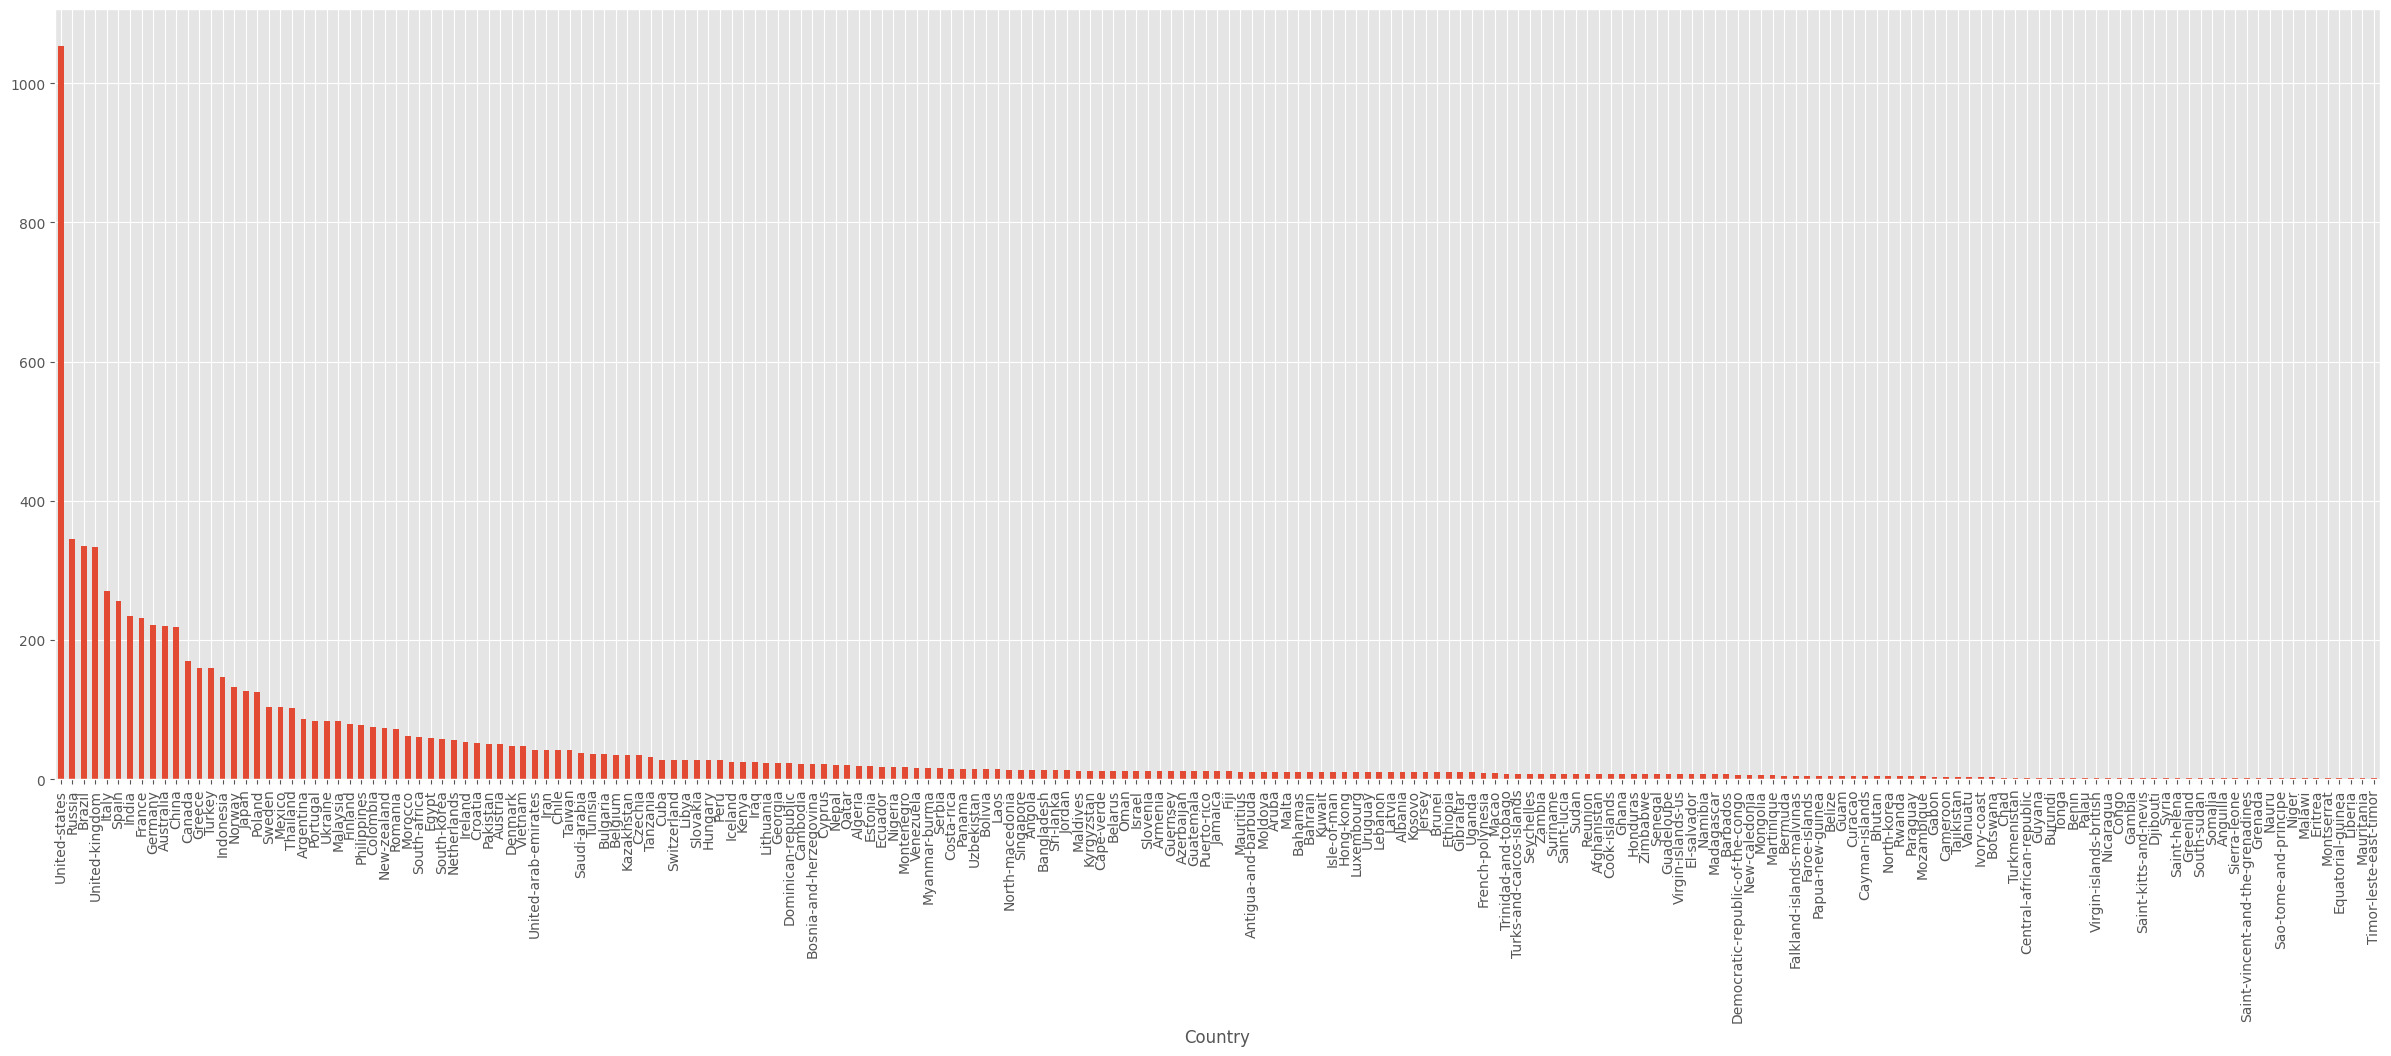

In [14]:
df_reviews["Country"].value_counts().plot.bar(figsize=(30, 10))

``Pareil pour les aeroports``
- En moyenne un aeroport à 4 avis, et une medianne de 3 avis
- L'aeroport avec le plus d'avis est ***Johannesburg OR Tambo International Airport*** (Afrique du sud), et celui avec le moins est ***Herat International Airport*** (Afghanistan)

In [48]:
df_reviews["Airport"].value_counts()

Airport
Johannesburg OR Tambo International Airport    20
Valencia Airport                               10
Reus Airport                                   10
Basel Mulhouse-Freiburg EuroAirport            10
Melilla Airport                                10
                                               ..
Matei Taveuni Airport                           1
Asmara International Airport                    1
Bata Airport                                    1
Colombo Ratmalana Airport                       1
Herat International Airport                     1
Name: count, Length: 1726, dtype: int64

In [55]:
country_of_max_airport = df_reviews[df_reviews["Airport"] == "Johannesburg OR Tambo International Airport"]["Country"].values[0]
country_of_min_airport = df_reviews[df_reviews["Airport"] == "Herat International Airport"]["Country"].values[0]

print(f"Country of the airport with the most reviews: {country_of_max_airport}")
print(f"Country of the airport with the least reviews: {country_of_min_airport}")

Country of the airport with the most reviews: South-africa
Country of the airport with the least reviews: Afghanistan


In [15]:
df_reviews["Airport"].value_counts().describe()

count    1726.000000
mean        4.733488
std         3.721415
min         1.000000
25%         1.000000
50%         3.000000
75%        10.000000
max        20.000000
Name: count, dtype: float64

<Axes: xlabel='Airport'>

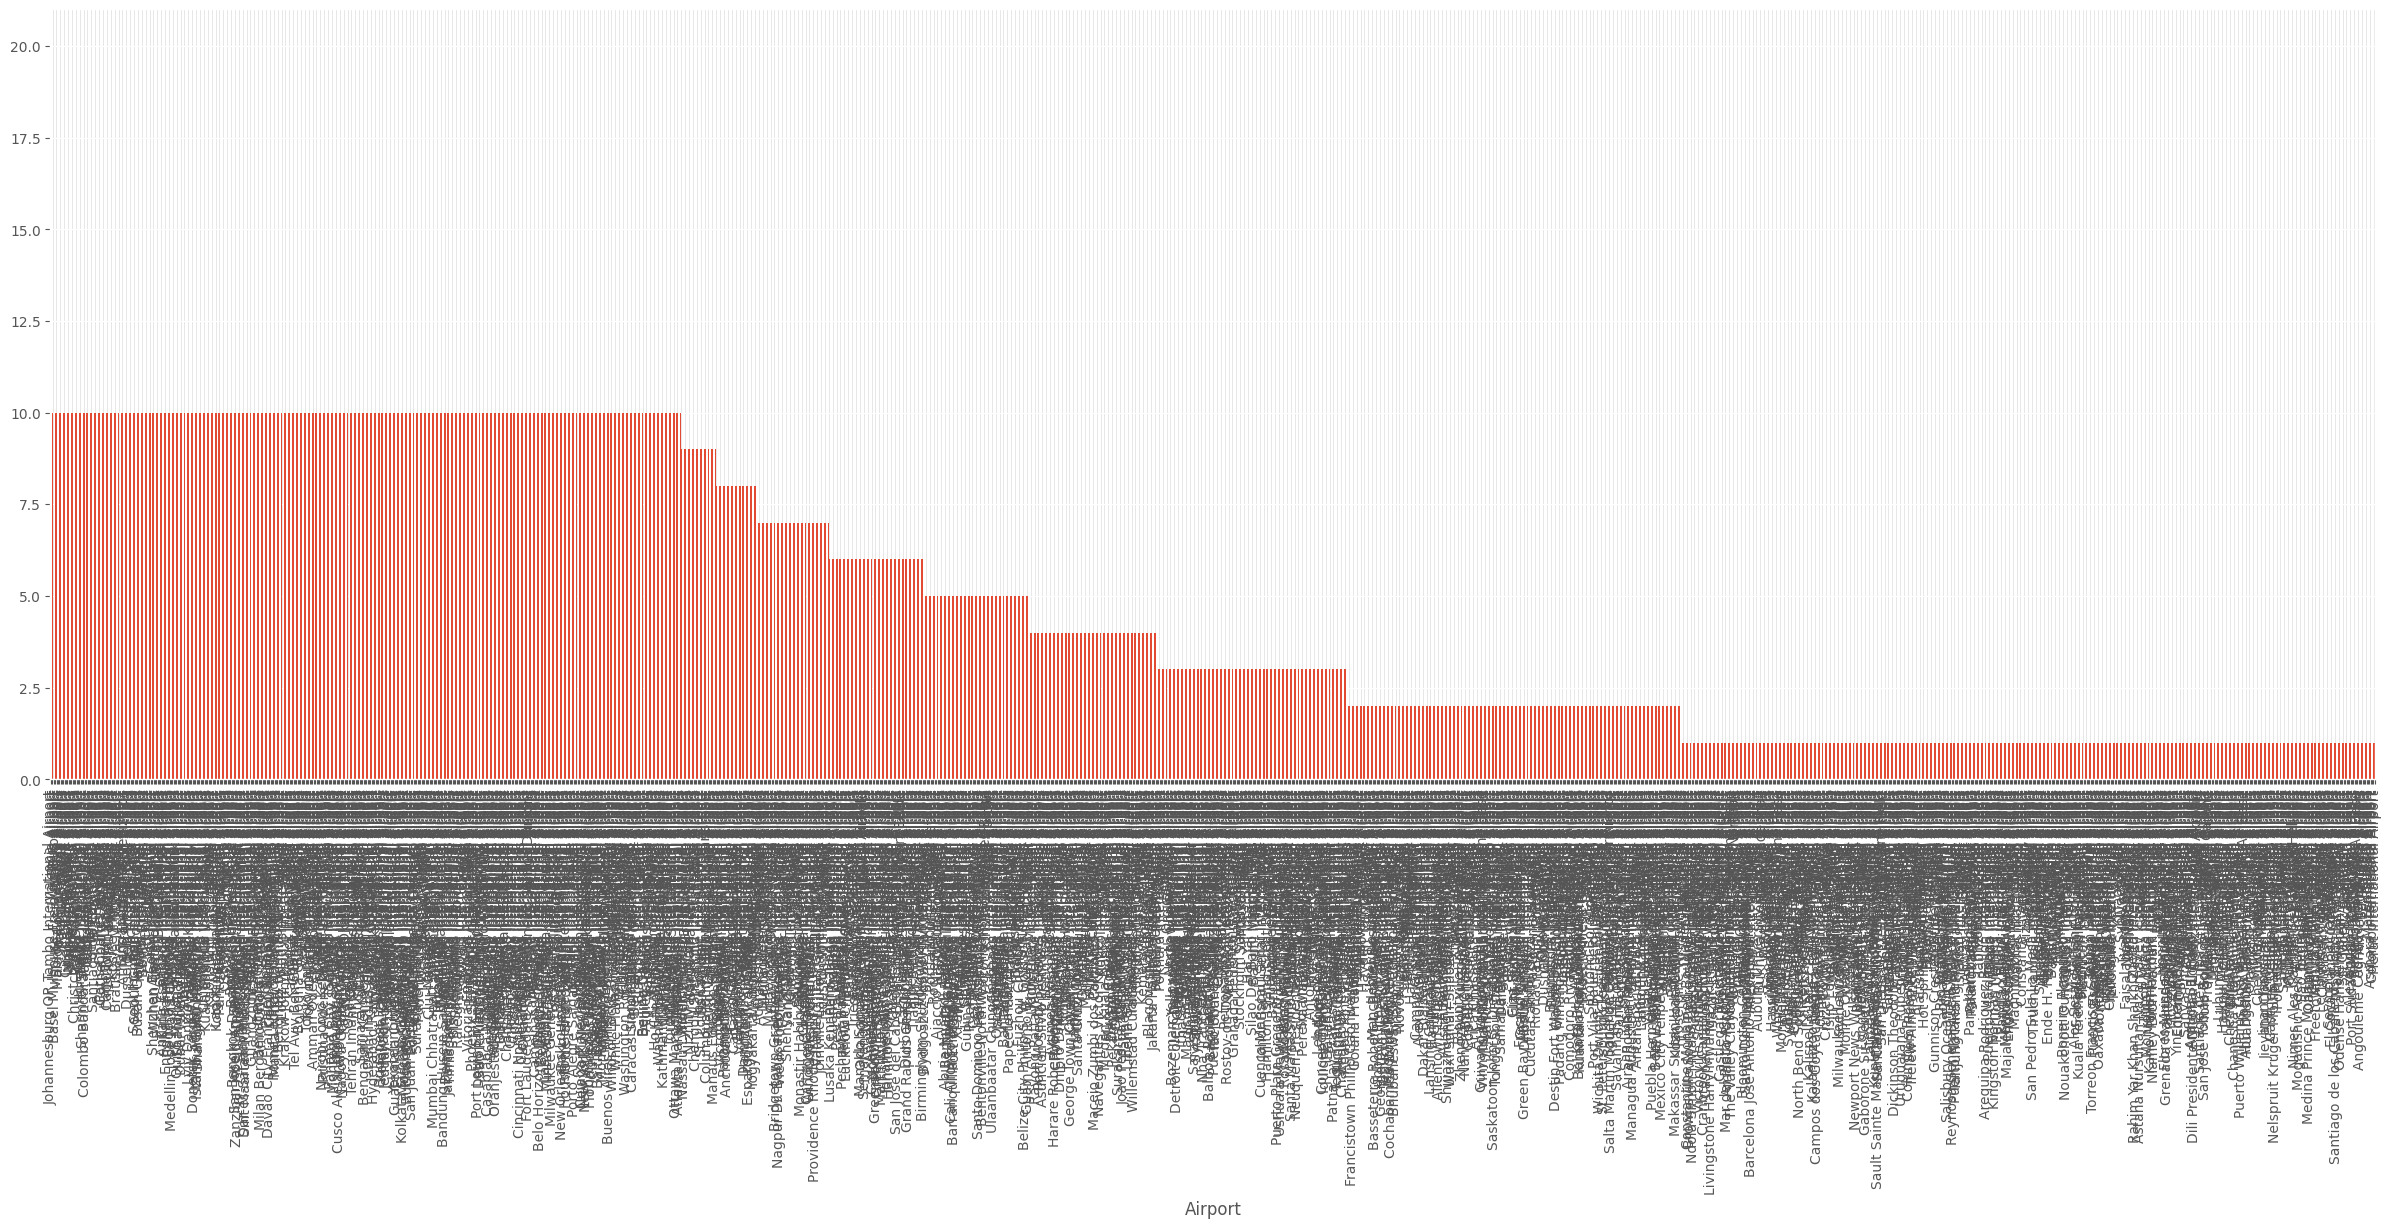

In [16]:
df_reviews["Airport"].value_counts().plot.bar(figsize=(30, 10))

``Nombre d'aeroport unique par pays``
- Un pays à en moyenne 8 aeroport, et la medianne est à 2, cependant 25% des pays on 1 seul aeroport, est ce que c'est suffisant pour tiré une conclusion sur ce pays ? => Probablement pas
- Comme le montre la répartition, les Etats unis sont le pays avec le plus d'aeroport unique

In [47]:
df_reviews["Airport"].groupby(df_reviews["Country"]).unique().apply(len).describe()

count    201.000000
mean       8.587065
std       21.391205
min        1.000000
25%        1.000000
50%        2.000000
75%        6.000000
max      249.000000
Name: Airport, dtype: float64

``Repartition du nombre d'aeroport unique par pays``

<Axes: xlabel='Country'>

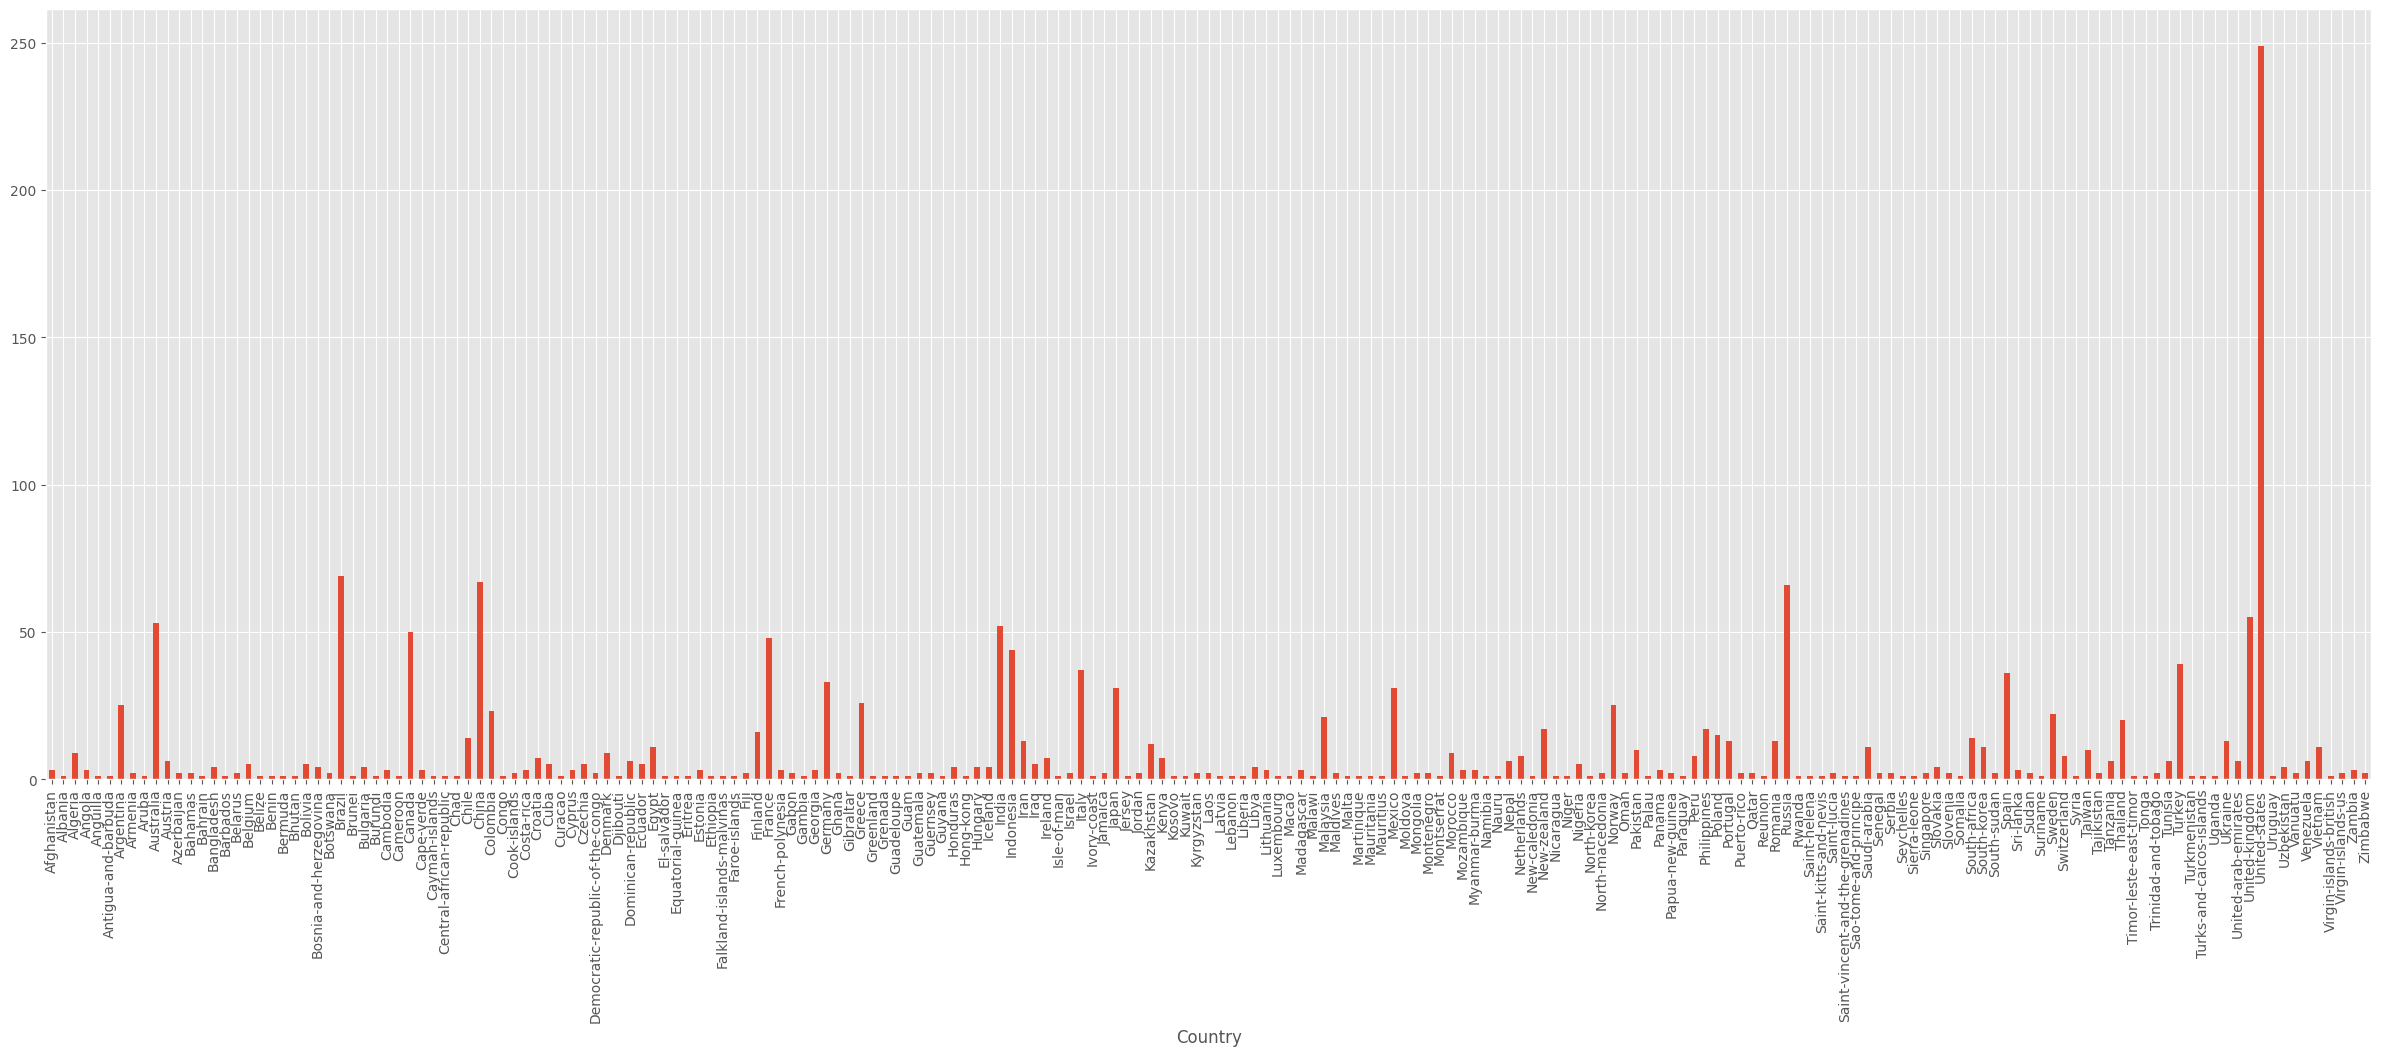

In [46]:
df_reviews["Airport"].groupby(df_reviews["Country"]).unique().apply(len).plot.bar(figsize=(30, 10))